In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import altair as alt
alt.renderers.enable('mimetype');
alt.data_transformers.enable('json');

import pickle

# Load the functions
import sys
sys.path.insert(1, '../../src')
from preprocessing import*
from quantile_regression_functions import*
from model_evaluation import*

# Linear Quantile Regression Notebook

Linear quantile regression is a regression technique similar to least square regression because it is concerned with linear relationships between response and explanatory variables. The difference is that linear quantile regression does not model the conditional mean, instead it models the conditional $nth$ quantile. To use linear quantile regression to generate a distribution, we regress over multiple quantiles and combine the results to create a distribution. 

For the baseline model we used outputs from the R function `auto.arima` to determine the ideal number of lags across all 17 gauges, which was three lags. We then fit the model to the 3 lagged flow values. When working with the daily data, we found that decomposing the flow data across a julian day resulted in better model performance. However, with hourly flow data when fitting the model we did not decompose the flow data since it did not improve performance. 

We improved the baseline model by creating a function for a linear quantile regression model that  allowed the number of lags to be modified, and for the NARR data to be added. Though there was improvement by adding spatial data, it was not significant. We believe better results can be obtained by adding features that can capture the signal of flow rate change.

A disadvantage to using linear quantile regression is that it makes a linear assumption and can only capture linear relationships between the response and predictors. Furthermore, the linear assumption may result in the occasional nonsense prediction, for example, when the quantile lines cross each other, we may get higher values for 0.7-quantile than the 0.8-quantile. To solve these problems, we turned to the tree-based models.


## Preprocessing

Run `python QR_preprocessing.py` in the terminal to combine flow data that was grouped by distance (see [`NARR_data_processing.ipynb`](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/NARR_data_processing.ipynb) file for more information). This is done for implementation of NARR features later in the notebook.

In [2]:
# Read training and validation sets from the saved pickle files
with open('../../data/pickle/qr_hourly_train.pickle', 'rb') as handle:
    df_train = pickle.load(handle)
with open('../../data/pickle/qr_hourly_val.pickle', 'rb') as handle:
    df_val = pickle.load(handle)

Below the end of the training data set and the beginning of the validation data set have been shown to the split captures a continous section of time.

In [3]:
df_train.tail()

,Value,year,day,hour,q1_apcp,q1_ssrun,q1_snom,q1_soilm,q2_apcp,q2_ssrun,q2_snom,q2_soilm,q3_apcp,q3_ssrun,q3_snom,q3_soilm,q4_apcp,q4_ssrun,q4_snom,q4_soilm
time,,,,,,,,,,,,,,,,,,,,
2017-06-04 03:00:00+00:00,326.866128,2017,155,3,0.012753,0.000306,0.0,261.59537,0.003907,0.000590,0.001180,112.610820,0.016332,0.002053,0.008617,165.2089,0.007825,0.000746,0.01812,123.577160
2017-06-04 04:00:00+00:00,324.017140,2017,155,4,0.012753,0.000306,0.0,261.59537,0.003907,0.000590,0.001180,112.610820,0.016332,0.002053,0.008617,165.2089,0.007825,0.000746,0.01812,123.577160
2017-06-04 05:00:00+00:00,321.168056,2017,155,5,0.001407,0.000000,0.0,261.57852,0.005590,0.000147,0.000295,112.600876,0.003626,0.000000,0.000000,165.2305,0.001960,0.000000,0.00316,123.596085
2017-06-04 06:00:00+00:00,318.726136,2017,155,6,0.001407,0.000000,0.0,261.57852,0.005590,0.000147,0.000295,112.600876,0.003626,0.000000,0.000000,165.2305,0.001960,0.000000,0.00316,123.596085
2017-06-04 07:00:00+00:00,317.505127,2017,155,7,0.001407,0.000000,0.0,261.57852,0.005590,0.000147,0.000295,112.600876,0.003626,0.000000,0.000000,165.2305,0.001960,0.000000,0.00316,123.596085


In [4]:
df_val.head()

,Value,year,day,hour,q1_apcp,q1_ssrun,q1_snom,q1_soilm,q2_apcp,q2_ssrun,q2_snom,q2_soilm,q3_apcp,q3_ssrun,q3_snom,q3_soilm,q4_apcp,q4_ssrun,q4_snom,q4_soilm
time,,,,,,,,,,,,,,,,,,,,
2017-06-04 08:00:00+00:00,317.098060,2017,155,8,0.038223,0.003728,0.0,261.57413,0.016895,0.000901,0.000000,112.59958,0.015280,0.002053,0.000000,165.22772,0.010762,0.001468,0.002211,123.59748
2017-06-04 09:00:00+00:00,315.470081,2017,155,9,0.038223,0.003728,0.0,261.57413,0.016895,0.000901,0.000000,112.59958,0.015280,0.002053,0.000000,165.22772,0.010762,0.001468,0.002211,123.59748
2017-06-04 10:00:00+00:00,313.842102,2017,155,10,0.038223,0.003728,0.0,261.57413,0.016895,0.000901,0.000000,112.59958,0.015280,0.002053,0.000000,165.22772,0.010762,0.001468,0.002211,123.59748
2017-06-04 11:00:00+00:00,312.621093,2017,155,11,0.000754,0.000000,0.0,261.56510,0.001821,0.006194,0.011651,112.60146,0.001027,0.015953,0.032313,165.22100,0.000000,0.006605,0.053597,123.59874
2017-06-04 12:00:00+00:00,310.993114,2017,155,12,0.000754,0.000000,0.0,261.56510,0.001821,0.006194,0.011651,112.60146,0.001027,0.015953,0.032313,165.22100,0.000000,0.006605,0.053597,123.59874


## Train the model

To train the model, three different sets of predictor are used. The first set is only the lagged flow data, the next set includes precipitation and surface runoff for only the quater of NARR data closest to the gauge. The final set again includes precipitation and surface runoff, but also included soil moisture for the quater of the watershed closest to the gauge. These predictors can be changed in the [`QR_train.py`](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Linear_Quantile_Reg/QR_train.py) script.

Please run `python QR_train.py` in the terminal if you want to re-train the models and re-save the predicted results in the `data/pickle` folder as pickle files. It may take long to train the model. Please note that the parameters of the models and the predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Linear_Quantile_Reg/QR_train.py).

**NOTE**: You **DO NOT** need to train the model to run this notebook. The results have already been stored in the `data/pickle` folder.

In [5]:
# Read result of model without NARR from the saved pickle files
with open('../../data/pickle/qr_without_NARR.pickle', 'rb') as handle:
    without_NARR = pickle.load(handle)

The results of the linear quantile regression model with different predictors are shown below. Comparing the first plot of only flow data, to the second plot with total accumulative precipitation and surface runoff we can see that the distributions narrow with the additon of the spatial variables. 

The addition of the soil moisture doesn't narrow the distribution, but it centers the predicted values within the distribution. This shows that the addition of the soil moisture creates a distribution more likley to include higher flow values, which is valuable as we are concerned with high flow events.

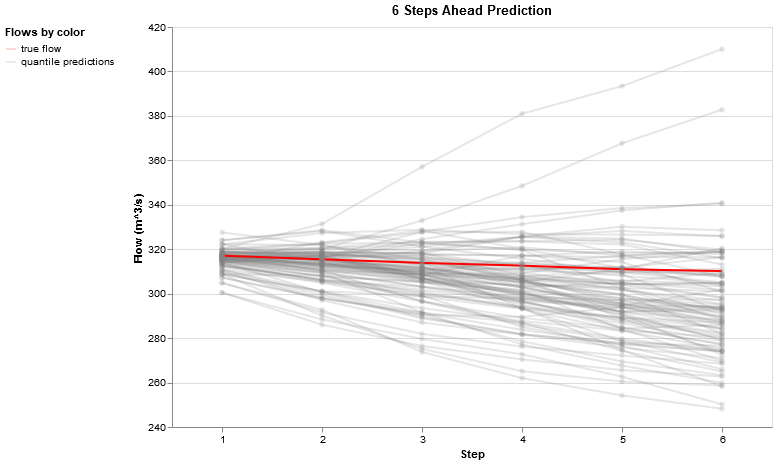

In [6]:
plot_multiple_step_prediction(df_train, df_val, without_NARR, hourly=True, width=600, height=400)

In [7]:
# Read result of model with NARR from the saved pickle files
with open('../../data/pickle/qr_with_NARR.pickle', 'rb') as handle:
    NARR = pickle.load(handle)

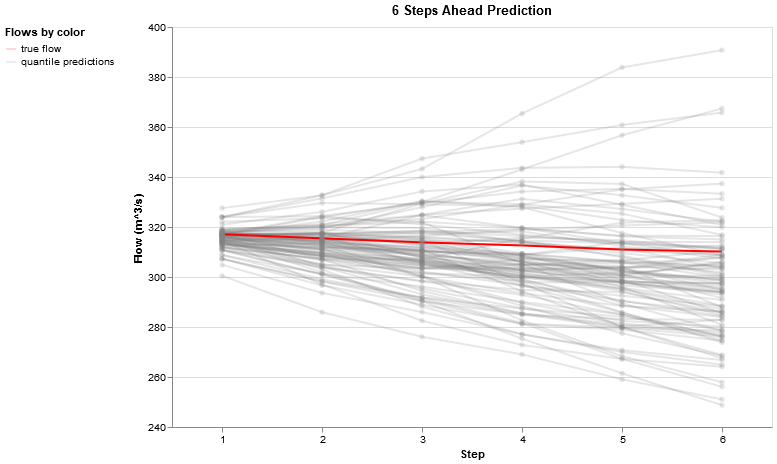

In [8]:
plot_multiple_step_prediction(df_train, df_val, NARR, hourly=True, width=600, height=400)

In [9]:
# Read result of model without NARR from the saved pickle files
with open('../../data/pickle/qr_with_NARR_soilm.pickle', 'rb') as handle:
    NARR_solim = pickle.load(handle)

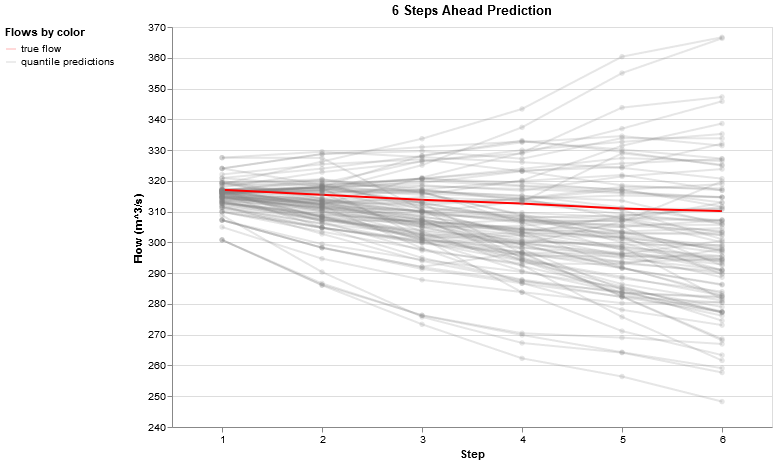

In [10]:
plot_multiple_step_prediction(df_train, df_val, NARR_solim, hourly=True, width=600, height=400)